<a href="https://colab.research.google.com/github/YonggunJung/ICT_TensorFlow/blob/main/20231005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! unzip /content/cat_dog_small.zip

Archive:  /content/cat_dog_small.zip
   creating: test/
   creating: test/cats/
  inflating: test/cats/cat.1500.jpg  
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflat

In [2]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

train_dir = '/content/train'
validation_dir = '/content/validation'



In [7]:
# ImageDataGenerator 생성
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 30,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True
                                   )

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'],   # cats folder로부터 나온 이미지는 target이 0
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],   # cats folder로부터 나온 이미지는 target이 0
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
# Transfer Learning(전이 학습)
# Pretrained Network을 사용

model_base = VGG16(weights = 'imagenet',
                   include_top = False,
                   input_shape = (150, 150, 3))

# Pretrained Network 안의 모든 layer를 동결 (update가 안되도록 처리)
model_base.trainable = False


# 모델 학습
model = Sequential()

model.add(model_base)

model.add(Flatten(input_shape=(4 * 4 * 512,)))

model.add(Dense(units=256,
                activation='relu'))

model.add(Dropout(rate=0.5))

model.add(Dense(units=1,
                activation='sigmoid'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 2097665 (8.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
Epoch 1/

In [10]:
# Fine Tuning(미세조정)
# Pretrained Network에서 일부 layer를 동결에서 해제
# 동결을 해제한 층을 같이 학습에 이용해서 다시 학습 진행

model_base.trainable = True # 동결에서 해제


for layer in model_base.layers:
  if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3' ]:
    layer.trainable = True # 동결해제
  else:
    layer.trainable = False # update 안되게 그대로 동결

model_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [11]:
# 위의 코드로 일부 layer을 동결 해제 후 재학습 진행
# 재 학습시 일반적으로 learning_rate를 줄여서 처리

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=20,
                    validation_data=validation_generator,
                    validation_steps=50,
                    verbose=1)

Epoch 1/20
100/100 [==============================] - 23s 190ms/step - loss: 0.1873 - accuracy: 0.9215 - val_loss: 0.2452 - val_accuracy: 0.9010
Epoch 2/20
100/100 [==============================] - 21s 206ms/step - loss: 0.1698 - accuracy: 0.9295 - val_loss: 0.2253 - val_accuracy: 0.9210
Epoch 3/20
100/100 [==============================] - 18s 181ms/step - loss: 0.1456 - accuracy: 0.9410 - val_loss: 0.2206 - val_accuracy: 0.9170
Epoch 4/20
100/100 [==============================] - 18s 180ms/step - loss: 0.1390 - accuracy: 0.9450 - val_loss: 0.2365 - val_accuracy: 0.9080
Epoch 5/20
100/100 [==============================] - 19s 185ms/step - loss: 0.1275 - accuracy: 0.9535 - val_loss: 0.2350 - val_accuracy: 0.9170
Epoch 6/20
100/100 [==============================] - 18s 182ms/step - loss: 0.1144 - accuracy: 0.9555 - val_loss: 0.2181 - val_accuracy: 0.9310
Epoch 7/20
100/100 [==============================] - 20s 204ms/step - loss: 0.1013 - accuracy: 0.9610 - val_loss: 0.2062 - val_ac

<ipython-input-12-62c4ec560b9b>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(train_acc, 'bo', color='r', label='training accuracy')
<ipython-input-12-62c4ec560b9b>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(val_acc, 'b', color='b', label='validation accuracy')


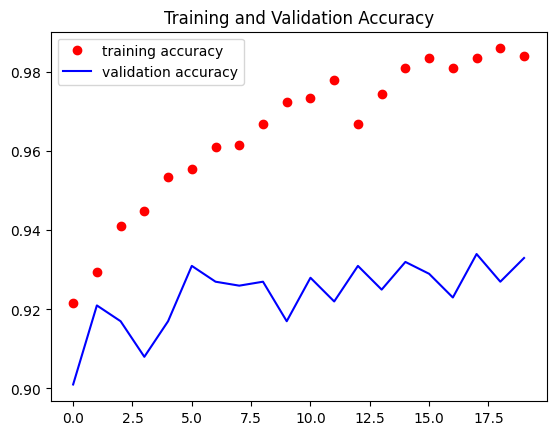

<ipython-input-12-62c4ec560b9b>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(train_loss, 'bo', color='r', label='training loss')
<ipython-input-12-62c4ec560b9b>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(val_loss, 'b', color='b', label='validation loss')


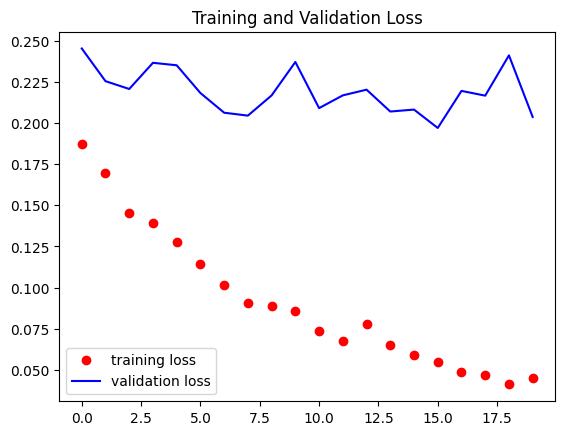

In [12]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc, 'bo', color='r', label='training accuracy')
plt.plot(val_acc, 'b', color='b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(train_loss, 'bo', color='r', label='training loss')
plt.plot(val_loss, 'b', color='b', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [13]:
# 결국 4000개의 개와 고양이 실사이미지를 가지고
# 전이학습(Fine Tuning)을 진행하면 accuracy 가 93% 정도 되는 모델 구현 가능
# 만약 25000개의 이미지 모두 사용 하면 거의 96%정도 나옴


In [15]:
# 여기서 조금 더 나은 모델을 만들려면?
# Pretrained Network을 조금 더 좋은 모델로 변경
# 특성을 더 잘 뽑아서주는, 레이어가 많은걸로 변경

# 마지막으로 EfficientNet을 이용해서 Fine Tuning을 진행
# EfficientNet B4 사용

# EfficientNet은 keras에 포함되어 있지 않음, 별도 설치 필요
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.8 MB/s eta 0:00:00


In [16]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.1 MB/s eta 0:00:00


In [17]:
# EfficientNet B4를 이용한 Fine Tuning

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
import cv2 # opencv(이미지처리의 대표적 library)

In [32]:
train_dir = '/content/train'
validation_dir = '/content/validation'

IMAGE_SIZE = 256  # Pretrained Network에 들어가는 이미지의 가로, 세로 크기
BATCH_SIZE = 8    # ImageDataGenerator로 한번에 가져오는 이미지의 개수

# 함수 생성 : 이미지 전처리 담당
def image_preprocessing(img):
  # 이미지 전처리 코드가 여기에 들어옴
  # 이미지 반전, 이미지 흑백처리, 이미지 크롭처리, 이미지 크기변경처리
  # 등등의 이미지 전처리들을 여기로
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    return img

train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   preprocessing_function=image_preprocessing)

validation_datagen = ImageDataGenerator(rescale=1/255,
                                        preprocessing_function=image_preprocessing)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes = ['cats', 'dogs'],
    batch_size = BATCH_SIZE,
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes = ['cats', 'dogs'],
    batch_size = BATCH_SIZE,
    class_mode = 'binary'
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [33]:
# Pretrained Network

pretrained_model = efn.EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)
)

# pretrained_model.summary()

# 해당 모델 안의 레이어에 대해 필요시 수정 가능
pretrained_model.trainable = False

In [34]:
model = Sequential()

model.add(pretrained_model)

model.add(Flatten(input_shape=(8 * 8 * 1792,)))
model.add(Dense(units=256,
                activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1,
                activation='sigmoid'))

# EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   verbose=1,
                   patience=5)

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=(2000 // BATCH_SIZE),
                    epochs=50,
                    validation_data = validation_generator,
                    validation_steps = (1000 // BATCH_SIZE),
                    callbacks=[es],
                    verbose=1)

Epoch 1/50
250/250 [==============================] - 65s 210ms/step - loss: 0.3012 - accuracy: 0.8675 - val_loss: 0.0501 - val_accuracy: 0.9870
Epoch 2/50
250/250 [==============================] - 53s 211ms/step - loss: 0.2082 - accuracy: 0.9125 - val_loss: 0.0482 - val_accuracy: 0.9880
Epoch 3/50
250/250 [==============================] - 54s 215ms/step - loss: 0.1839 - accuracy: 0.9225 - val_loss: 0.0469 - val_accuracy: 0.9850
Epoch 4/50
250/250 [==============================] - 49s 198ms/step - loss: 0.1599 - accuracy: 0.9270 - val_loss: 0.0469 - val_accuracy: 0.9850
Epoch 5/50
250/250 [==============================] - 49s 198ms/step - loss: 0.1611 - accuracy: 0.9350 - val_loss: 0.0432 - val_accuracy: 0.9870
Epoch 6/50
250/250 [==============================] - 45s 181ms/step - loss: 0.1423 - accuracy: 0.9405 - val_loss: 0.0451 - val_accuracy: 0.9870
Epoch 7/50
250/250 [==============================] - 46s 182ms/step - loss: 0.1501 - accuracy: 0.9400 - val_loss: 0.0425 - val_ac

In [ ]:
# 학습이 종료된 후에 일부 layer의 동결을 해제한후 (상위 layer)
# 재학습을 진행(Fine Tuning) 조금더 성능 개선 확인 가능
# 이미 99%라 힘들지도